# Hierarchical Bayesian Neural Network for Efficient High-dimensional Asset Return Prediction.
> Improving efficiency by sharing information between asset specific neural networks via informative priors.

- toc: true 
- badges: true
- comments: true
- categories: [efficiency, hierarchical, deep learning, probabilistic programming, bayesian, panel]



Financial assets exhibit hierarchical structure. They belong to classes such as stocks or bonds, are country specific, belong to sectors and industries, and load on other common risk factors.

Stocks may have different conditional expectations given their sector, for example. To build performant models, these differences need to be modeled. 

In the following, a panel data set of asset returns is simulated. By construction, the unconditional expectation (i.e., the expectation ignoring the dependence on sectors) is equal to zero. Hence, a pooled model is unable to fit the data.

There are different ways to fit the model:

- fit pooled data (here: impossible to achieve a good fit.)
- fit data independently per sector (inefficient)
- encode sector as feature and fit pooled data
- use hierarchical model


Why is there a need for hierarchical models when neural networks are very good at learning asset encodings internally given relevant features? Consider what happens if each asset has a different and independent data generating function. Then you would need an one-hot encoding matrix with dimensions $np \times p$. If $n$ is not very large relative to $p$, the asset encoding might be hard to learn. A Bayesian approach allows each asset specific neural network to deviate from the group model *if and only if* there is sufficient evidence to conclude that it follows a different data generating process.

In a Bayesian framework we could also model the multiple levels of the hierarchical structure explicitly. The overall net may serve as a prior for sector nets, which, in turn, may serve as priors for asset specific nets. 

In [1]:
#hide
! pip install hfhd==0.1.4
! pip install numba==0.51.2


In [2]:
#hide
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from pymc3 import HalfNormal, GaussianRandomWalk, Bernoulli
from pymc3.math import sigmoid
import theano.tensor as tt
from theano.tensor.slinalg import Cholesky

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'


import pandas as pd
import seaborn as sns
import tqdm
from datetime import timedelta
from hfhd import hf
from hfhd import hd
from hfhd import sim
import datetime
from functools import partial
import torch
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
# %matplotlib notebook


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def mse(y_hat, y):
    return ((y_hat - y)**2).mean()
    

In [4]:
def get_ir(log_rets, Y_hat, inv_cov_tensor):

    w = torch.einsum('np, npj -> nj', Y_hat, inv_cov_tensor).detach().numpy()
    opt_weights = w / np.abs(w).sum(axis=1)[:, None]
    portfolio_ret = np.einsum('ij, ij->i', opt_weights, log_rets)
    ir = np.mean(portfolio_ret) / np.std(portfolio_ret) * np.sqrt(252)
    return ir, portfolio_ret

# Data Generation

The following snipped generates a panel data set with sector dependent nonlinear conditional expectation. You may want to open it in Colab and play with different valuess for ``n_stocks, n_days, n_ind``.

In [5]:

def add_daily_trend_to_log_price(log_price, feature_list, beta_list):
    """
    This function adds a daily trend to high-frequency simulations.
    """
    for beta, feature in zip(beta_list, feature_list):
        signal = pd.DataFrame(log_price).copy()
        signal.iloc[:, :] = np.nan

        for i in set(signal.index.date):
            for c in signal.columns:
                signal.loc[signal.index.date == i, c] =\
                   feature[feature.index == i][c].values * beta / n_periods
        signal_cumsum = signal.cumsum()
        log_price += signal_cumsum


# Hyperparams
n_stocks = 50
n_days = 100
n_ind = 25
pct_train = 0.1


factor_loadings = np.linspace(1, 3, n_stocks)[:, None]
npi = int(n_stocks/n_ind)
industry_loadings = np.zeros((n_stocks, n_ind))
for i in range(n_ind):
    industry_loadings[i*npi:(i+1)*npi, i] = np.ones(npi)[:]

# beta
feature_beta = industry_loadings  @ np.linspace(-1,1, n_ind)
# np.random.shuffle(feature_beta)

# Use only intraday returns for cov estimation
d = 1

# High-frequency prices are irregularly sampled
# proportion of sampled prices
liq = 1#0.8

# Prices are contaminated with micro structure noise
# 10ct per $100 ms noise
gamma = 0#0.1/100

# mins per day
n_periods = 6.5*60

# GARCH(1,1) spec
sigma_sq_0 = 0.1**2/250/n_periods
garch_alpha = 0#0.019
garch_beta = 0#0.98
omega = sigma_sq_0*(1-garch_alpha-garch_beta)

# preaveraging parameters
k = int(0.5*(n_periods)**(0.5))

pairwise = True

# NERIVE parameters
L = 4
stp = hd._get_partitions(L)

# condition number targeting parameters
max_cond_target = 800
max_iter = 100
step = 0.05

estimators = {
                #  'realized_cov': partial(hf.mrc, pairwise=False, theta=0),
                  # 'msrc': partial(hf.msrc, pairwise=pairwise, M=M, N=N),
                  'mrc': partial(hf.mrc, pairwise=pairwise, theta=None, k=k),
                  # 'hy': partial(hf.hayashi_yoshida, theta=None, k=k),
                  # 'krvm': partial(hf.krvm, H=H, pairwise=pairwise,
                  #  kernel=hf.parzen_kernel),
                  # 'epic': partial(hf.ensemble, var_weights=np.ones(4)/4,
                  # cov_weights=np.ones(4)/4),
                 }


u = sim.Universe(0,
          [sigma_sq_0, 0, garch_alpha, garch_beta, omega],
          [sigma_sq_0, 0, garch_alpha, garch_beta, omega],
          [sigma_sq_0, 0, garch_alpha, garch_beta, omega],
          factor_loadings,
          industry_loadings,
          liq,
          gamma,
          'm',
          )
u.simulate(n_days)
price = u.price

feature_daily = np.random.normal(0, 0.1, n_days*n_stocks).reshape(n_days, n_stocks)
feature2_daily = np.random.normal(0, 0.1, n_days*n_stocks).reshape(n_days, n_stocks)

# add a daily predictable mean to high-frequency data
signal = feature_beta * feature_daily * feature2_daily

signal_df = pd.DataFrame(signal,
                          index=pd.Series(list(set(price.index.date))).sort_values(),
                          columns=price.columns)
log_price = np.log(price)
add_daily_trend_to_log_price(log_price, [signal_df], [1.])
price = np.exp(log_price)

price_daily_close = price.resample('1d').last()
price_daily_open = price.resample('1d').first()
log_rets_daily = np.log(price_daily_close) - np.log(price_daily_open)

X = torch.tensor([feature_daily, feature2_daily]).permute(1, 0, 2).float()
Y = torch.tensor(log_rets_daily.values).float()

n_time_steps_train = int(n_days*pct_train)
n_time_steps_valid = n_days - n_time_steps_train

covs_nerive = {key: [] for key in estimators.keys()}

# Compute the integrated covariance matrices.
for i in log_rets_daily.index.date[:n_time_steps_train]:
    p = price[(price.index.date < i+timedelta(days=d))&(price.index.date > i-timedelta(days=d))]
    l = [hf.get_cumu_demeaned_resid(p.iloc[:, j]) for j in range(price.shape[1])]
    for name, estimator in estimators.items():

            cov = estimator(l)
            # covs[name].append(cov)

            if max_cond_target is None:
                covs_nerive[name].append(hd.nerive(l, estimator=estimator, stp=stp))
            else:
                covs_nerive[name].append(hd.linear_shrink_target(
                    hd.nerive(l, estimator=estimator, stp=stp),
                    max_cond_target, step, max_iter))

# split into train and valid set
Y_train = Y[:n_time_steps_train, :]
X_train = X[:n_time_steps_train, :, :]

Y_valid = Y[n_time_steps_train:, :]
X_valid = X[n_time_steps_train:, :, :]

# normalize
train_mean = X_train.mean(keepdim=True, dim=(0, 2))
train_std = X_train.std(keepdim=True, dim=(0, 2))
X_train = (X_train - train_mean) / train_std
X_valid = (X_valid - train_mean) / train_std








/usr/local/lib/python3.6/dist-packages/hfhd/hf.py:1204: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  cov[i, i] = _mrc(data, theta, g, bias_correction, k)[0, 0]
/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [6]:
#hide
feature_beta


array([-1.        , -1.        , -0.91666667, -0.91666667, -0.83333333,
       -0.83333333, -0.75      , -0.75      , -0.66666667, -0.66666667,
       -0.58333333, -0.58333333, -0.5       , -0.5       , -0.41666667,
       -0.41666667, -0.33333333, -0.33333333, -0.25      , -0.25      ,
       -0.16666667, -0.16666667, -0.08333333, -0.08333333,  0.        ,
        0.        ,  0.08333333,  0.08333333,  0.16666667,  0.16666667,
        0.25      ,  0.25      ,  0.33333333,  0.33333333,  0.41666667,
        0.41666667,  0.5       ,  0.5       ,  0.58333333,  0.58333333,
        0.66666667,  0.66666667,  0.75      ,  0.75      ,  0.83333333,
        0.83333333,  0.91666667,  0.91666667,  1.        ,  1.        ])

In [7]:
inv_cov_tensor = torch.tensor([np.linalg.inv(c) for c in u.cond_cov()])[n_time_steps_train:]

The following covariance matrix and dendrogram show the hierarchical structure of asset returns.

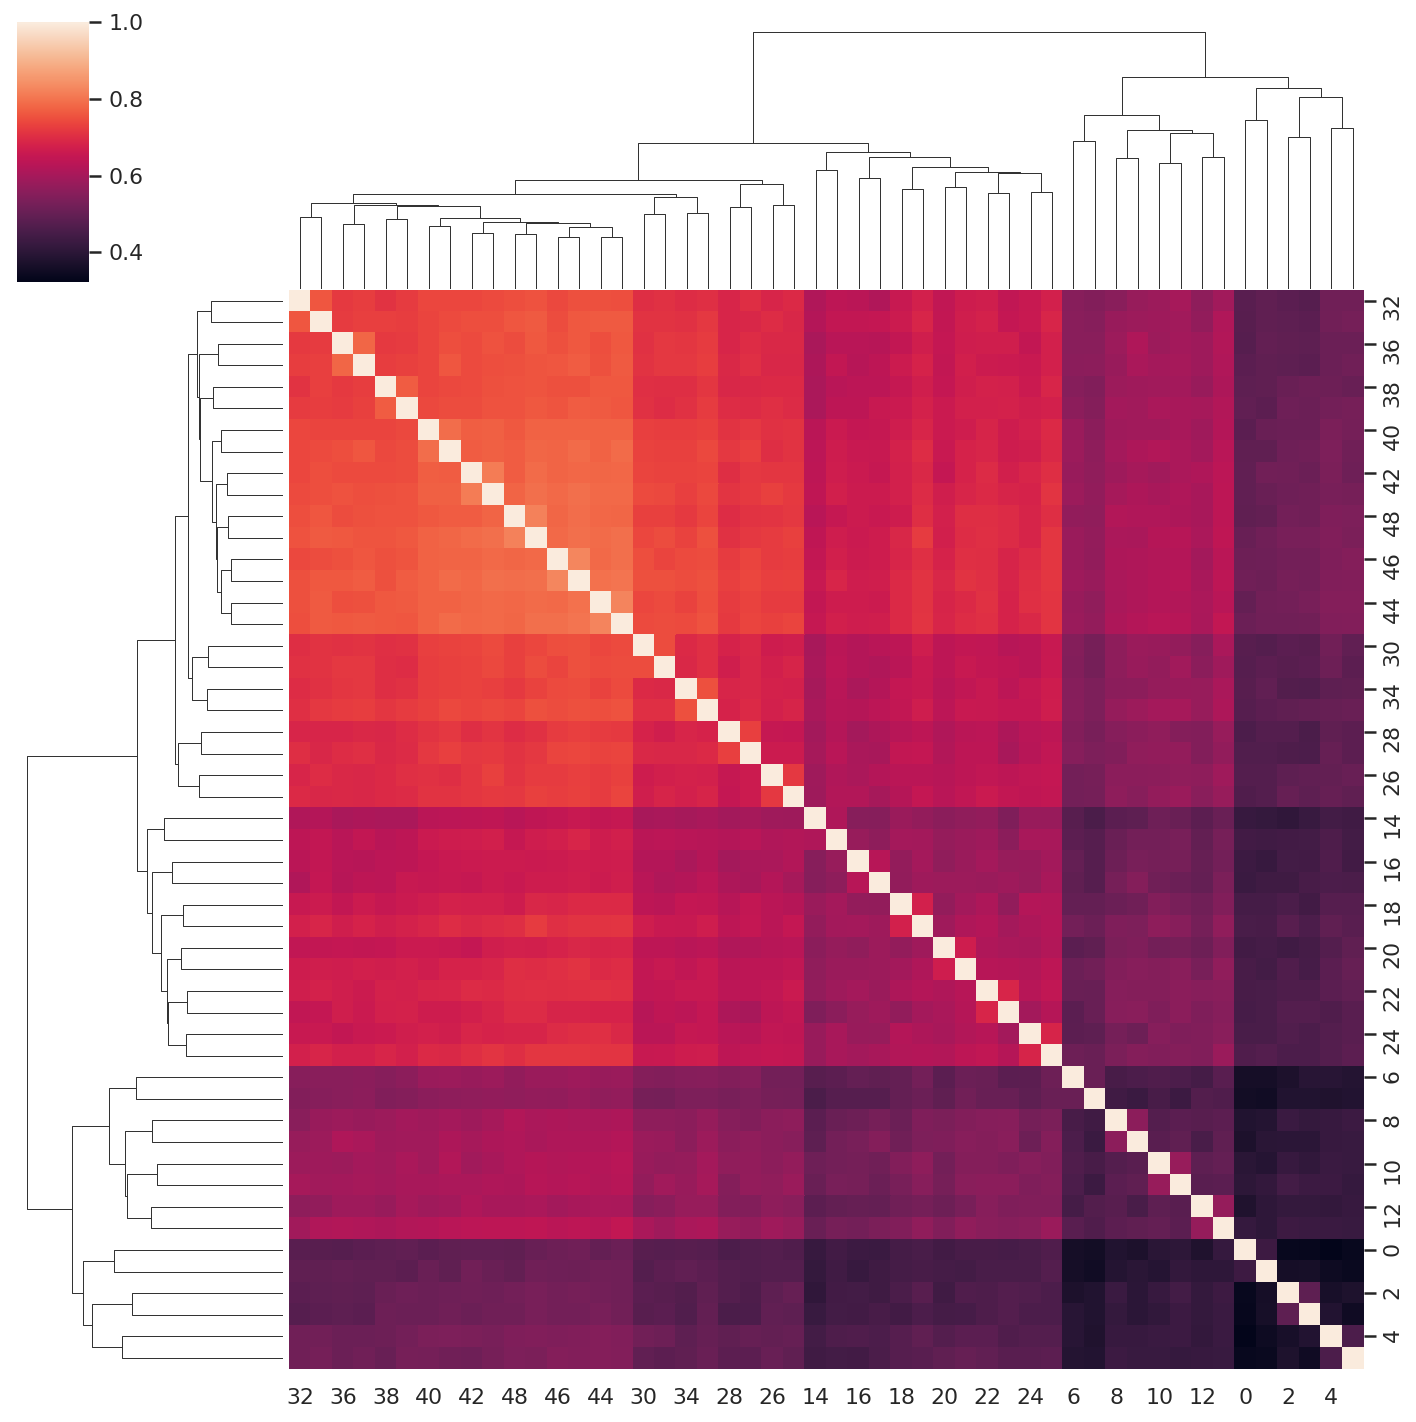

In [8]:
cov_avg = np.array(covs_nerive['mrc'])[:n_time_steps_train].mean(0)
corr = hd.to_corr(cov_avg)
sns.clustermap(corr)

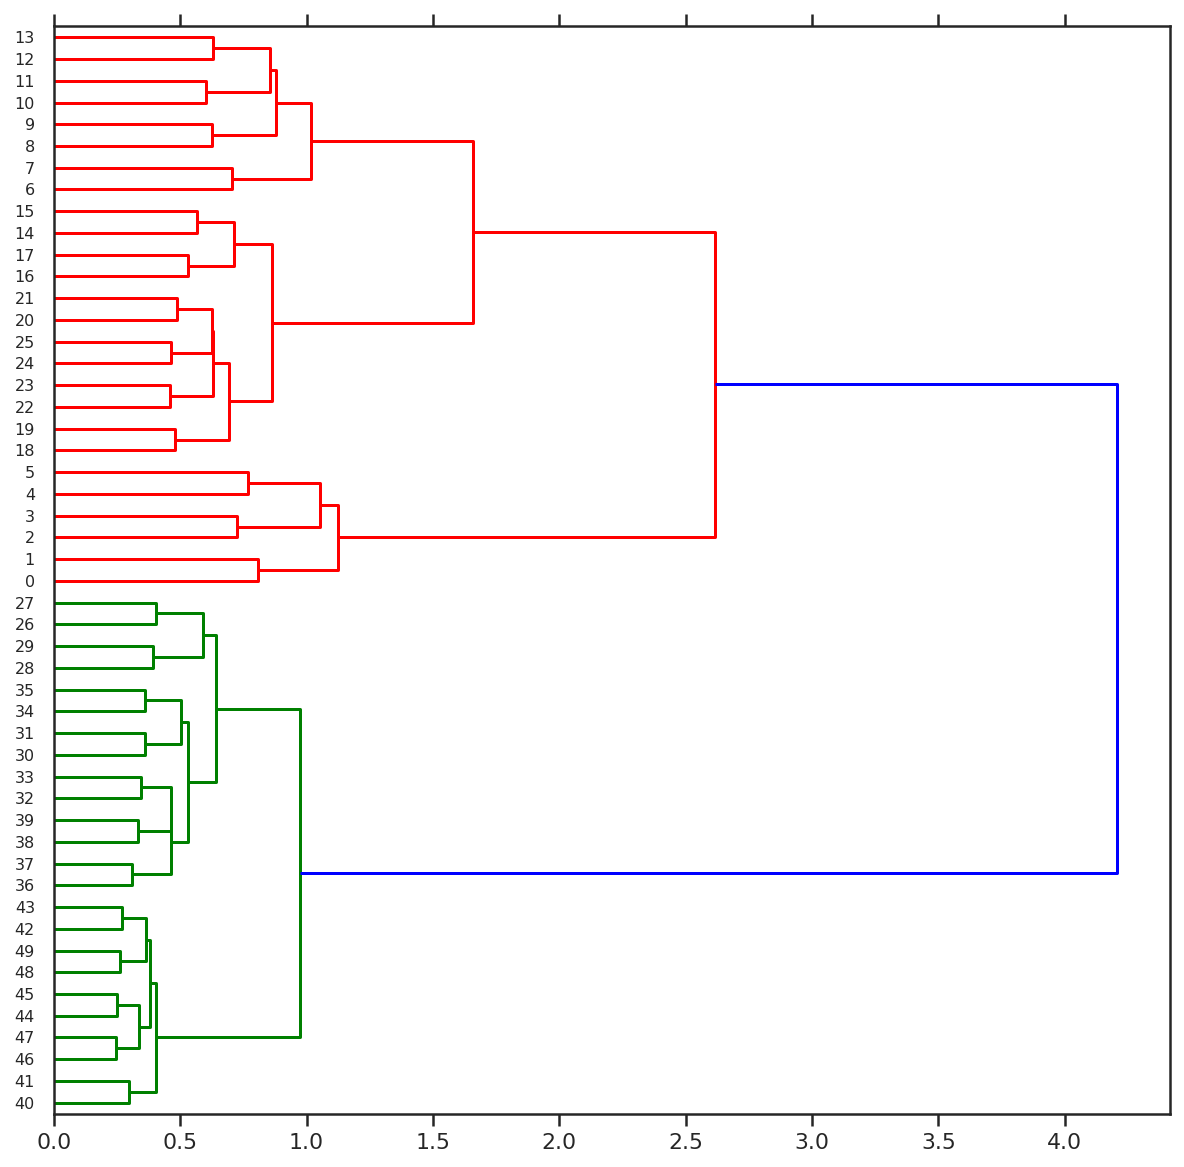

In [9]:

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(corr) 

fig, ax = plt.subplots(figsize=(10, 10))
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(
    axis= 'x',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off'
               )

By construction the returns are not predictable without conditioning on the sector. The figure below illustrates this.

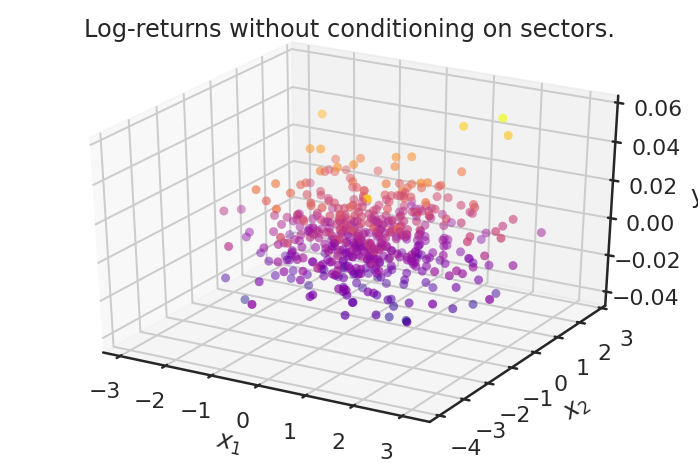

In [10]:

n = n_time_steps_train
p = n_stocks

x1 = X_train[:,0,:]
x2 = X_train[:,1,:]
y = Y_train


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('y');
ax.scatter(x1, x2, y, c=y, cmap='plasma', linewidth=0.0);
plt.title("Log-returns without conditioning on sectors.")
plt.show()

In [11]:


x1_train = np.empty((n_ind, X_train.shape[0], npi))
x2_train = np.empty_like(x1_train)
y_train = np.empty_like(x1_train)

x1_valid = np.empty((n_ind, X_valid.shape[0], npi))
x2_valid = np.empty_like(x1_valid)
y_valid = np.empty_like(x1_valid)

for i in range(n_ind):
  x1_train[i,:,:] = X_train[:,0,i*npi:(i+1)*npi]
  x2_train[i,:,:] = X_train[:,1,i*npi:(i+1)*npi]
  y_train[i,:,:] = Y_train[:, i*npi:(i+1)*npi]


  x1_valid[i,:,:] = X_valid[:,0,i*npi:(i+1)*npi]
  x2_valid[i,:,:] = X_valid[:,1,i*npi:(i+1)*npi]
  y_valid[i,:,:] = Y_valid[:, i*npi:(i+1)*npi]

The following figure shows the train set data points per sector. There are not enough observations to fit a seperate neural network to each sector without informative priors.

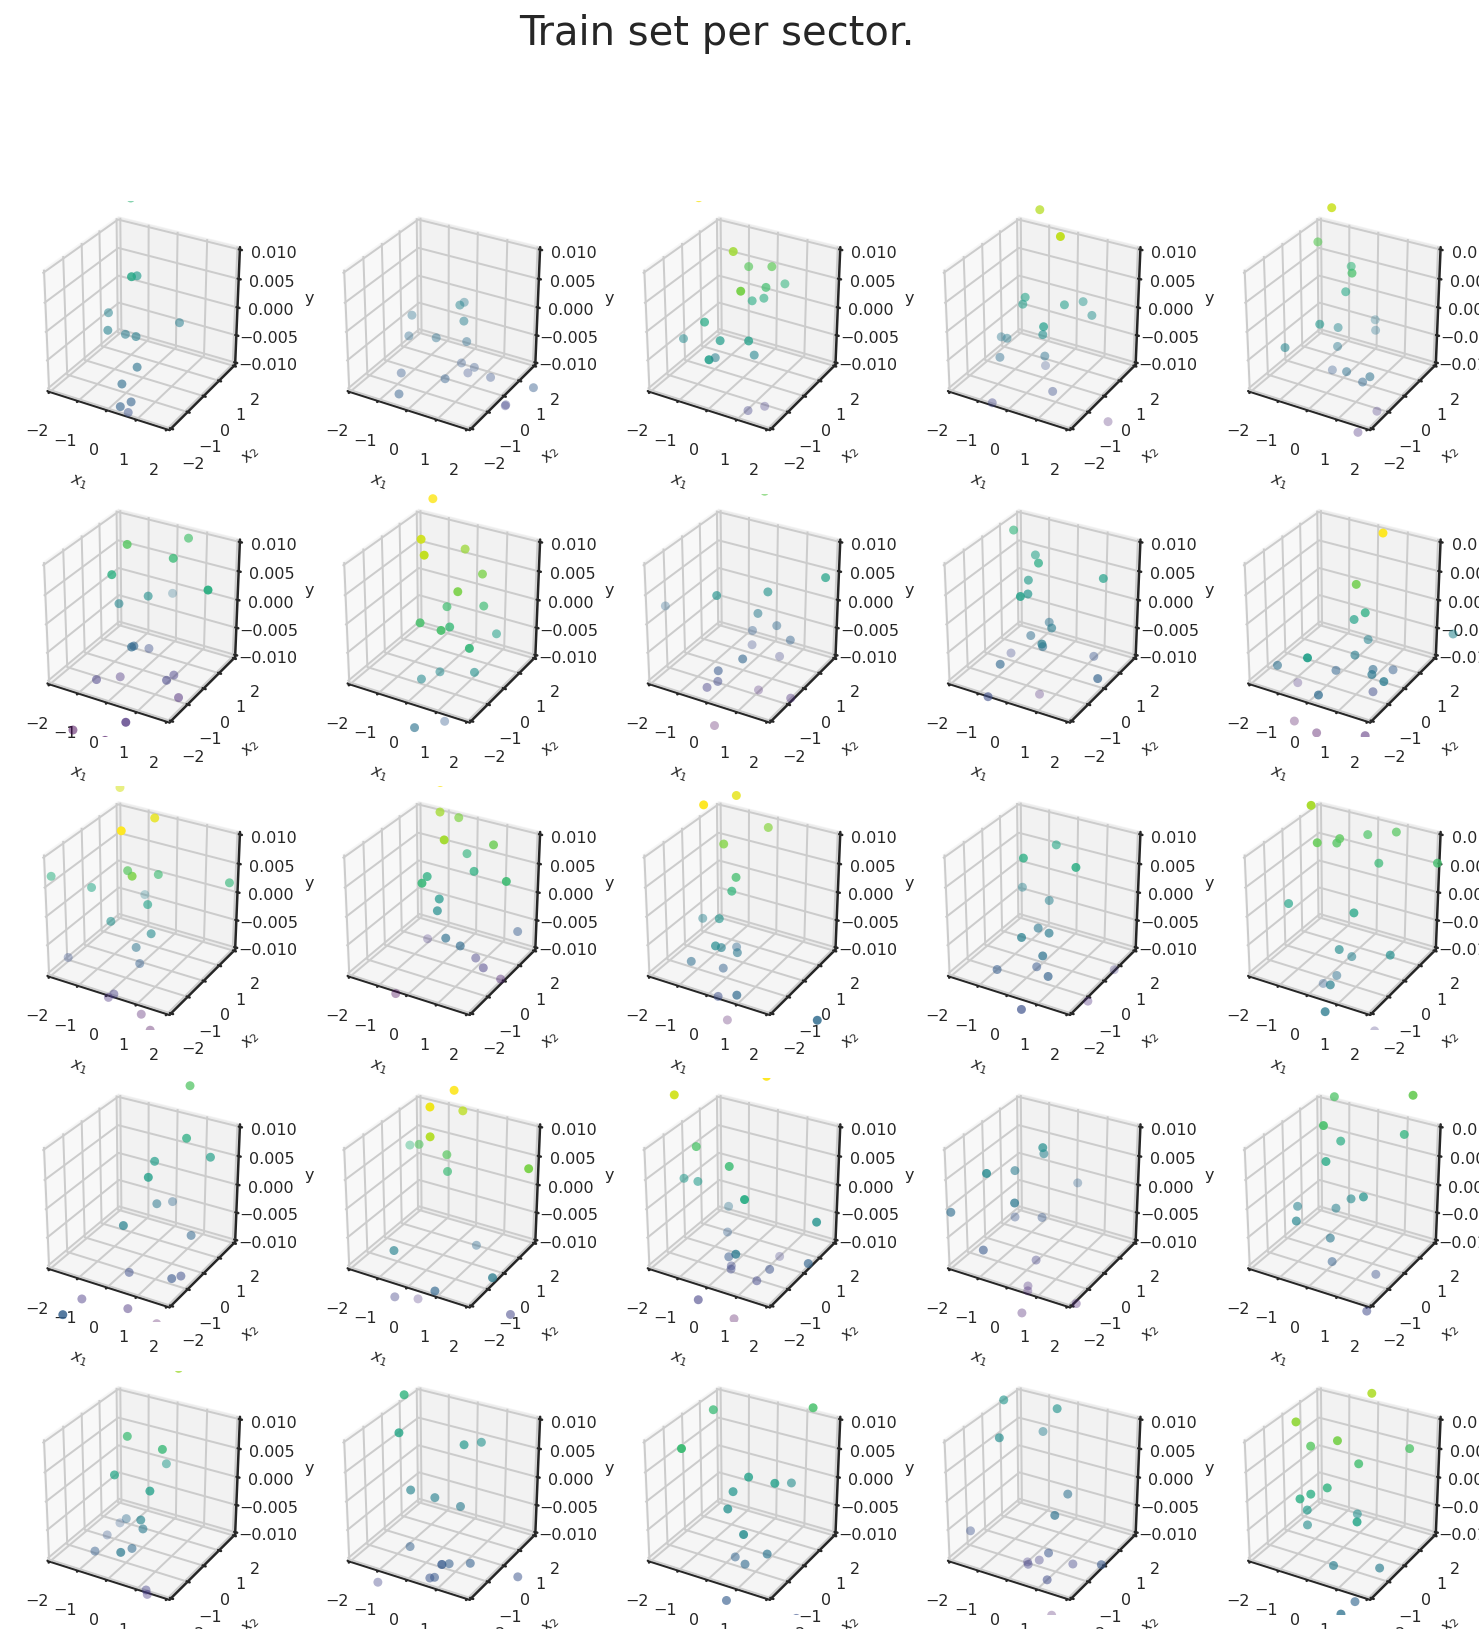

In [12]:

fig = plt.figure(figsize=(13,13))
fig.suptitle('Train set per sector.', fontsize=20)

for i in range(n_ind):
  ax = fig.add_subplot(np.ceil(np.sqrt(n_ind)), np.ceil(np.sqrt(n_ind)),
                       i+1, projection='3d')
  ax.set_xlabel('$x_1$', fontsize=8)
  ax.set_ylabel('$x_2$', fontsize=8)
  ax.set_zlabel('y', fontsize=8);
  ax.tick_params(labelsize=8);
  ax.set_xlim(-2, 2)
  ax.set_ylim(-2, 2)
  ax.set_zlim(-0.01, 0.01)
  ax.scatter(x1_train[i,:,:], x2_train[i,:,:], y_train[i,:,:],
             c=y_train[i,:,:], cmap='viridis', linewidth=0.0);

plt.show()

The next figure shows the test set data points per sector.

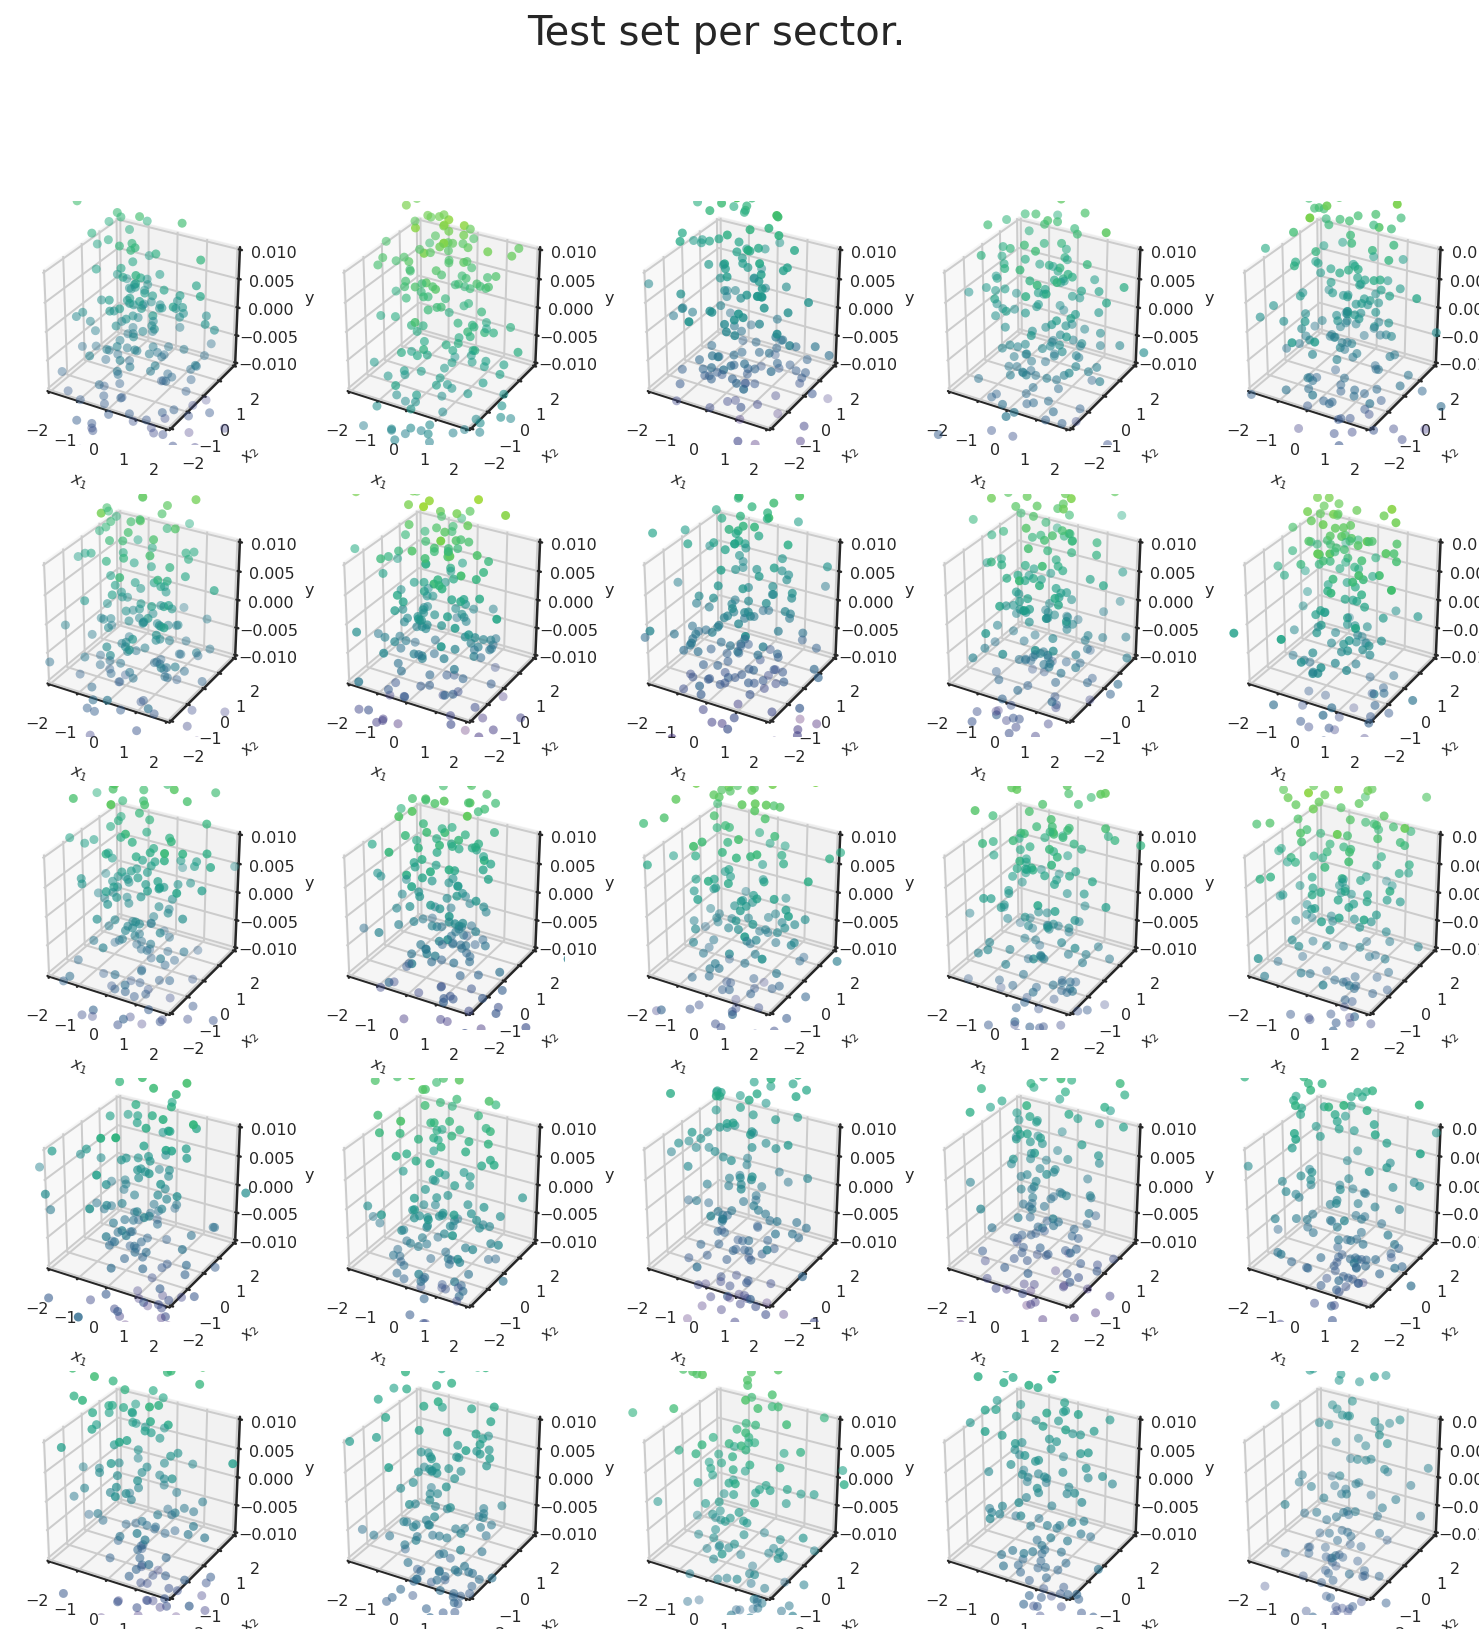

In [13]:
fig = plt.figure(figsize=(13,13))
fig.suptitle('Test set per sector.', fontsize=20)

for i in range(n_ind):
  ax = fig.add_subplot(np.ceil(np.sqrt(n_ind)), np.ceil(np.sqrt(n_ind)),
                       i+1, projection='3d')
  ax.set_xlabel('$x_1$', fontsize=8)
  ax.set_ylabel('$x_2$', fontsize=8)
  ax.set_zlabel('y', fontsize=8);
  ax.tick_params(labelsize=8);
  ax.set_xlim(-2, 2)
  ax.set_ylim(-2, 2)
  ax.set_zlim(-0.01, 0.01)
  ax.scatter(x1_valid[i,:,:], x2_valid[i,:,:], y_valid[i,:,:],
             c=y_valid[i,:,:], cmap='viridis', linewidth=0.0);

plt.show()

# Hierarchical Model

The following code defines a hierarchical Bayesian neural network with two hidden layers.

In [14]:
# This idea comes from:
# https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/.
# Non-centered specification of hierarchical model:
# see https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/
# Why?:
# https://www.youtube.com/watch?v=gSd1msFFZTw

X_train = np.stack((x1_train.reshape(n_ind, npi*n_time_steps_train),
                    x2_train.reshape(n_ind, npi*n_time_steps_train)), 2)
Y_train = y_train.reshape(n_ind, npi*n_time_steps_train)

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = [10, 5]
n_data = X_train.shape[2]
n_grps = n_ind

# Initialize random weights between each layer
init_1 = np.random.randn(n_data, n_hidden[0]).astype(theano.config.floatX)
init_2 = np.random.randn(n_hidden[0], n_hidden[1]).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden[1]).astype(theano.config.floatX)
    
with pm.Model() as neural_network:
    # Group mean distribution for input to hidden layer
    weights_in_1_grp = pm.Normal('w_in_1_grp', 0, sd=1, 
                              shape=(n_data, n_hidden[0]), 
                              testval=init_1)
    # Group standard-deviation
    weights_in_1_grp_sd = pm.HalfNormal('w_in_1_grp_sd', sd=1.)
    
    # Group mean distribution for weights from 1st to 2nd layer
    weights_1_2_grp = pm.Normal('w_1_2_grp', 0, sd=1, 
                            shape=(n_hidden[0], n_hidden[1]), 
                            testval=init_2)
    weights_1_2_grp_sd = pm.HalfNormal('w_1_2_grp_sd', sd=1.)
    
    # Group mean distribution from hidden layer to output
    weights_2_out_grp = pm.Normal('w_2_out_grp', 0, sd=1, 
                              shape=(n_hidden[1],), 
                              testval=init_out)
    weights_2_out_grp_sd = pm.HalfNormal('w_2_out_grp_sd', sd=1.)

    # Separate weights for each different model, just add a 3rd dimension
    # of weights
    weights_in_1_raw = pm.Normal('w_in_1', 
                                  shape=(n_grps, n_data, n_hidden[0]))
    
    weights_in_1 = weights_in_1_raw * weights_in_1_grp_sd + weights_in_1_grp
    
    weights_1_2_raw = pm.Normal('w_1_2', 
                                shape=(n_grps, n_hidden[0], n_hidden[1]))
    weights_1_2 = weights_1_2_raw * weights_1_2_grp_sd + weights_1_2_grp
    
    weights_2_out_raw = pm.Normal('w_2_out', 
                                  shape=(n_grps, n_hidden[1]))
    
    weights_2_out = weights_2_out_raw * weights_2_out_grp_sd + weights_2_out_grp

    
    
    # Build neural-network using relu activation function
    act_1 = tt.nnet.relu(tt.batched_dot(ann_input, 
                         weights_in_1))
    act_2 = tt.nnet.relu(tt.batched_dot(act_1, 
                         weights_1_2))
    
    # linear output layer
    intercept = pm.Normal('intercept', mu=0, sd=10)
    act_out = tt.batched_dot(act_2, weights_2_out) + intercept
        
    sigma = pm.HalfNormal('sigma', sd=10)
    out = pm.Normal('out', 
                    act_out,
                    sigma,
                    observed=ann_output)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [15]:
with neural_network:
    trace = pm.sample(init='advi+adapt_diag',  n_init=200000, tune=50, chains=1, 
                     nuts_kwargs={'target_accept': 0.9},)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = -1,286.5: 100%|██████████| 200000/200000 [06:38<00:00, 502.20it/s]
Finished [100%]: Average Loss = -1,285.8
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, intercept, w_2_out, w_1_2, w_in_1, w_2_out_grp_sd, w_2_out_grp, w_1_2_grp_sd, w_1_2_grp, w_in_1_grp_sd, w_in_1_grp]
100%|██████████| 550/550 [02:12<00:00,  4.14it/s]
The acceptance probability does not match the target. It is 0.6964927347812743, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


## Train set performance




In [16]:
ppc = pm.sample_posterior_predictive(trace, model=neural_network, samples=1000)
y_pred = ppc['out'].mean(0)


100%|██████████| 1000/1000 [00:15<00:00, 62.86it/s]


In [17]:
mse(y_pred, Y_train)

0.00015784721830155866

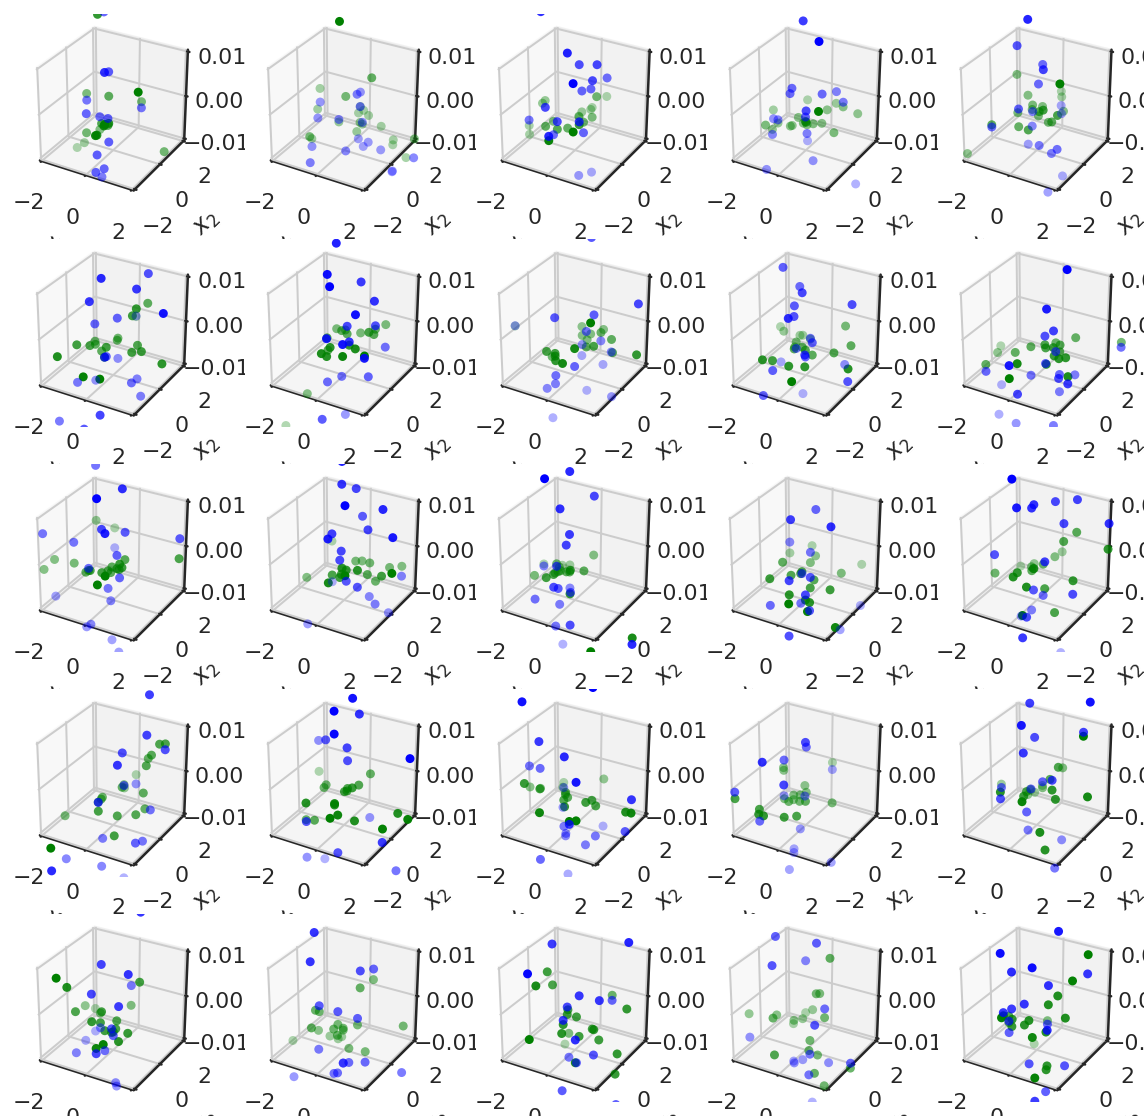

In [18]:
#hide
fig = plt.figure(figsize=(10,10))

for i in range(n_ind):
  ax = fig.add_subplot(np.ceil(np.sqrt(n_ind)), np.ceil(np.sqrt(n_ind)),
                       i+1, projection='3d')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_zlabel('y');
  ax.set_xlim(-2, 2)
  ax.set_ylim(-2, 2)
  ax.set_zlim(-0.01, 0.01)
  ax.scatter(x1_train[i,:,:], x2_train[i,:,:], y_pred[i,:],
             #c=y_pred[i,:],
             color='green',
             linewidth=0.0);
  ax.scatter(x1_train[i,:,:], x2_train[i,:,:], y_train[i,:,:],
             #c=y_train[i,:,:],
             #cmap='gray',
             c='blue',
             linewidth=0.0);


plt.show()

## Test set performance

In [19]:

X_valid = np.stack((x1_valid.reshape(n_ind, npi*n_time_steps_valid),
                    x2_valid.reshape(n_ind, npi*n_time_steps_valid)), 2)
Y_valid = y_valid.reshape(n_ind, npi*n_time_steps_valid)

ann_input.set_value(X_valid)
ann_output.set_value(Y_valid)
ppc = pm.sample_posterior_predictive(trace, model=neural_network, samples=1000)
y_hat_valid = ppc['out'].mean(0)


100%|██████████| 1000/1000 [00:17<00:00, 56.27it/s]


In [20]:
mse(y_hat_valid, Y_valid)    

0.00030787094680225093

The figure below shows the predictions (green) and targets (blue) per sector for the hierarchical model.

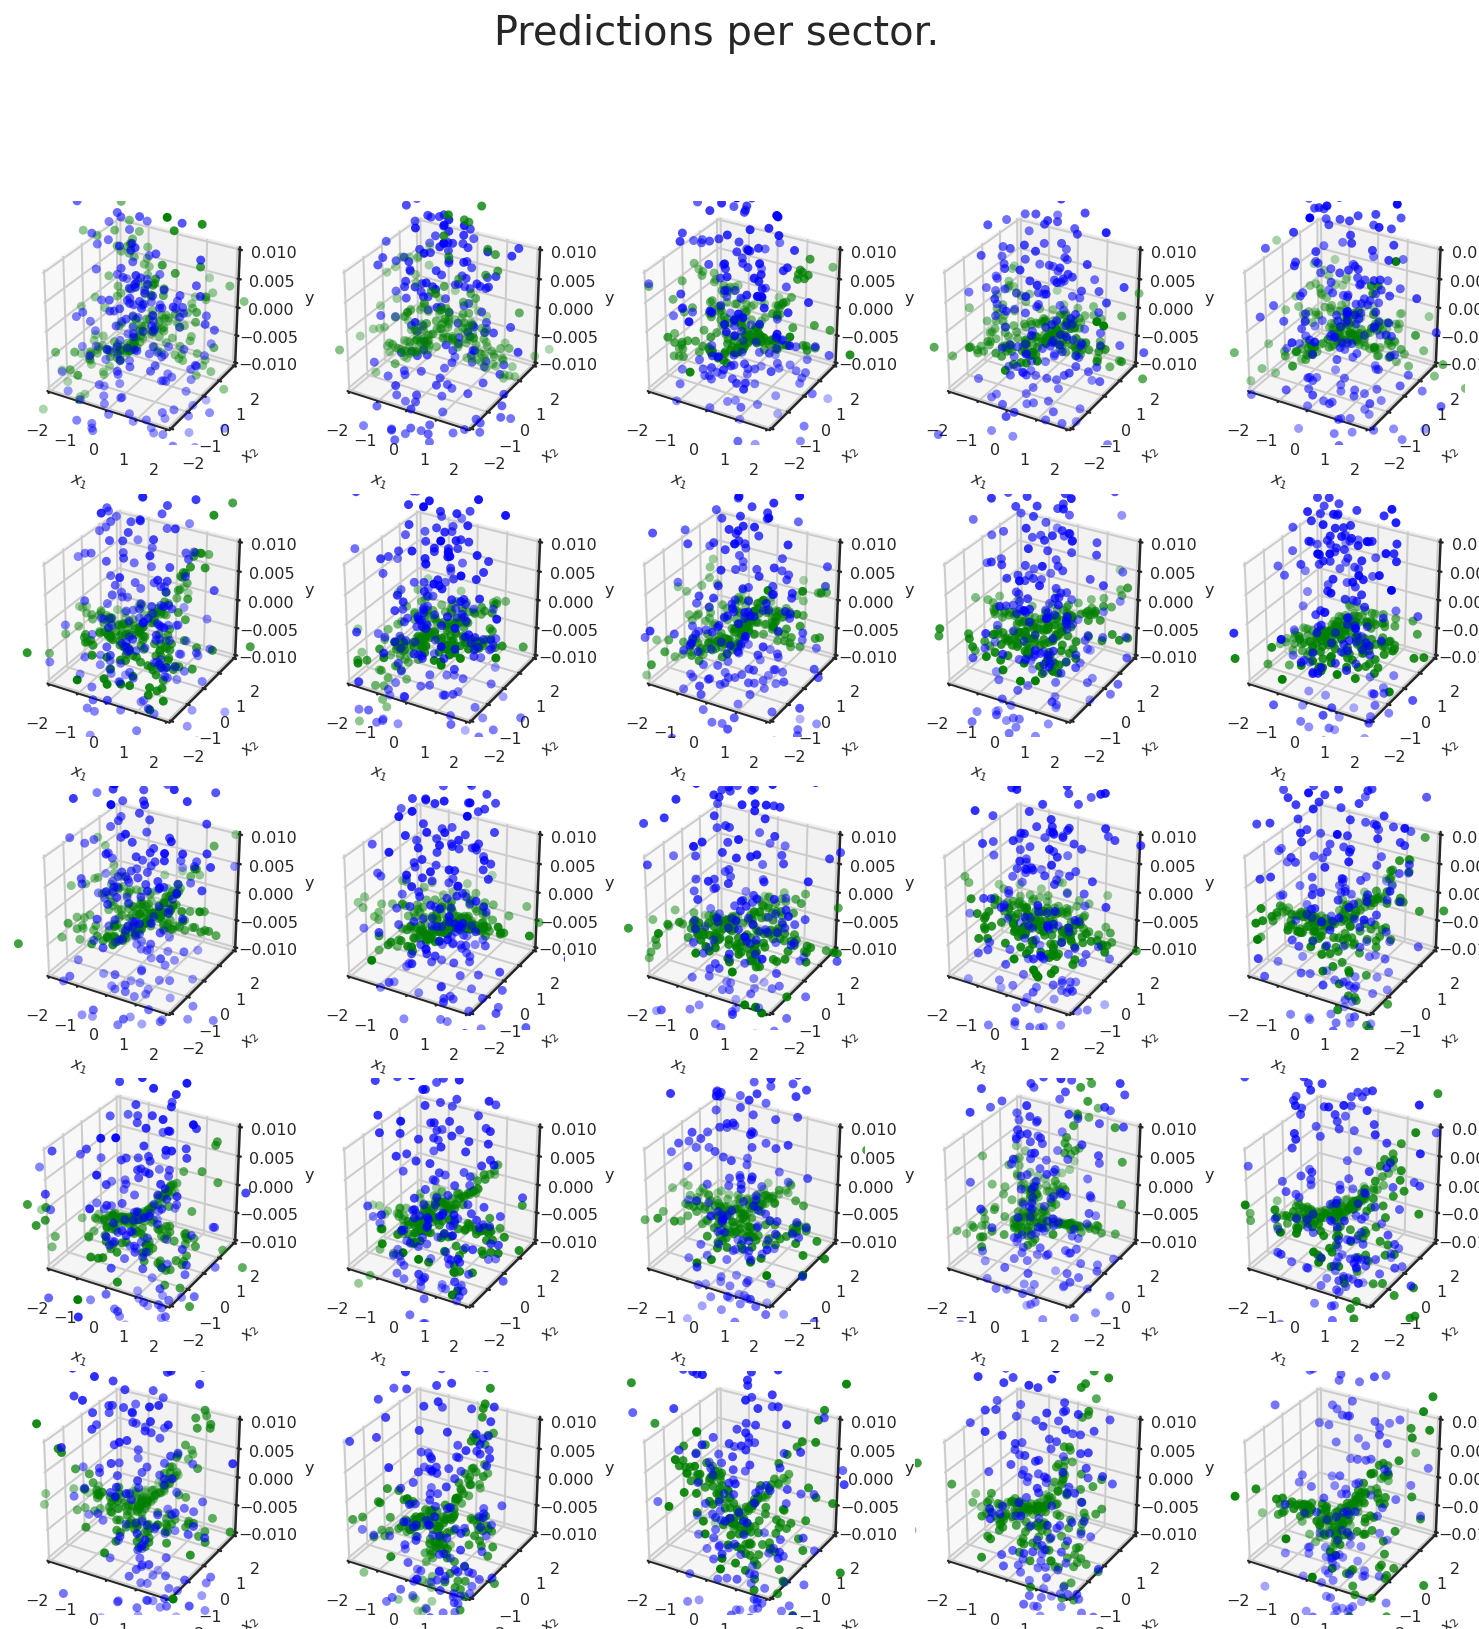

In [21]:
fig = plt.figure(figsize=(13,13))
fig.suptitle('Predictions per sector.', fontsize=20)

for i in range(n_ind):
  ax = fig.add_subplot(np.ceil(np.sqrt(n_ind)), np.ceil(np.sqrt(n_ind)),
                       i+1, projection='3d')
  ax.set_xlabel('$x_1$', fontsize=8)
  ax.set_ylabel('$x_2$', fontsize=8)
  ax.set_zlabel('y', fontsize=8);
  ax.tick_params(labelsize=8);
  ax.set_xlim(-2, 2)
  ax.set_ylim(-2, 2)
  ax.set_zlim(-0.01, 0.01)
  ax.scatter(x1_valid[i,:,:], x2_valid[i,:,:], y_hat_valid[i,:],
             #c=y_pred[i,:],
             #cmap='Greens',
             c='green',
             linewidth=0.0);
  ax.scatter(x1_valid[i,:,:], x2_valid[i,:,:], y_valid[i,:,:],
             #c=y_valid[i,:,:],
             #cmap='gray',
             c='blue',
             linewidth=0.0);


plt.show()

In [22]:
ir, rets = get_ir(log_rets=torch.tensor(Y_valid.reshape(n_stocks, n_time_steps_valid)).T,
       Y_hat=torch.tensor(y_hat_valid.reshape(n_stocks, n_time_steps_valid)).T,
       inv_cov_tensor=inv_cov_tensor)

Test set information ratio: 16.09347610446313


Text(0, 0.5, 'cumulative portfolio log-returns')

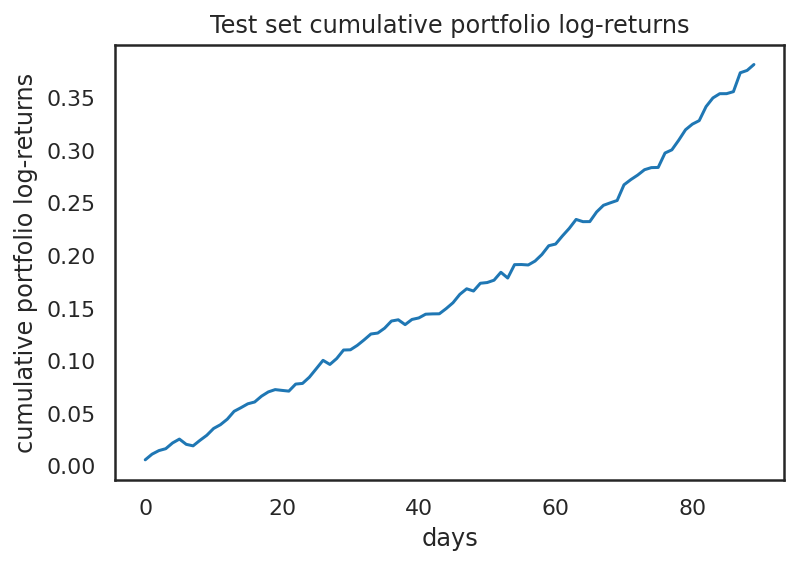

In [23]:
print('Test set information ratio:', ir)
plt.plot(np.cumsum(rets))
plt.title('Test set cumulative portfolio log-returns')
plt.xlabel('days')
plt.ylabel('cumulative portfolio log-returns')

# Industry one-hot encoding as feature

In [24]:


X_train = np.stack((x1_train.reshape(n_ind*npi*n_time_steps_train),
                    x2_train.reshape(n_ind*npi*n_time_steps_train)), 1)

# Comment the following line fit pooled model without industry feature
X_train = np.column_stack((X_train,
                           np.repeat(industry_loadings, n_time_steps_train, 0)))

Y_train = y_train.reshape(n_ind*npi*n_time_steps_train)


ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = [10, 5]
n_data = X_train.shape[1]


# Initialize random weights between each layer
init_1 = np.random.randn(n_data, n_hidden[0]).astype(theano.config.floatX)
init_2 = np.random.randn(n_hidden[0], n_hidden[1]).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden[1]).astype(theano.config.floatX)
    
with pm.Model() as neural_network:
    weights_in_1 = pm.Normal('w_in_1_grp', 0, sd=1, 
                              shape=(n_data, n_hidden[0]), 
                              testval=init_1)

    weights_1_2 = pm.Normal('w_1_2_grp', 0, sd=1, 
                            shape=(n_hidden[0], n_hidden[1]), 
                            testval=init_2)

    weights_2_out = pm.Normal('w_2_out_grp', 0, sd=1, 
                              shape=(n_hidden[1],), 
                              testval=init_out)

    # Build neural-network using relu activation function
    act_1 = tt.nnet.relu(tt.dot(ann_input, 
                         weights_in_1))
    act_2 = tt.nnet.relu(tt.dot(act_1, 
                         weights_1_2))
    
    # linear output layer
    intercept = pm.Normal('intercept', mu=0, sd=10)
    act_out = tt.dot(act_2, weights_2_out) + intercept
        
    sigma = pm.HalfNormal('sigma', sd=10)
    out = pm.Normal('out', 
                    act_out,
                    sigma,
                    observed=ann_output)

In [25]:

with neural_network:
    trace = pm.sample(
                     init='advi+adapt_diag', tune=50, chains=1,  n_init=200000,
                     nuts_kwargs={'target_accept': 0.9},)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = -806.87:  16%|█▌        | 31080/200000 [00:37<03:24, 825.65it/s]
Convergence achieved at 31100
Interrupted at 31,099 [15%]: Average Loss = 155.14
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, intercept, w_2_out_grp, w_1_2_grp, w_in_1_grp]
100%|██████████| 550/550 [03:16<00:00,  2.79it/s]
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6061956466236667, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


## Train set performance


In [26]:
ppc = pm.sample_posterior_predictive(trace, model=neural_network, samples=1000)
y_hat = ppc['out'].mean(0).reshape(n_ind, npi*n_time_steps_train)
mse(y_hat, Y_train.reshape(n_ind, npi*n_time_steps_train))    

100%|██████████| 1000/1000 [00:15<00:00, 66.64it/s]


0.00019588963829589306

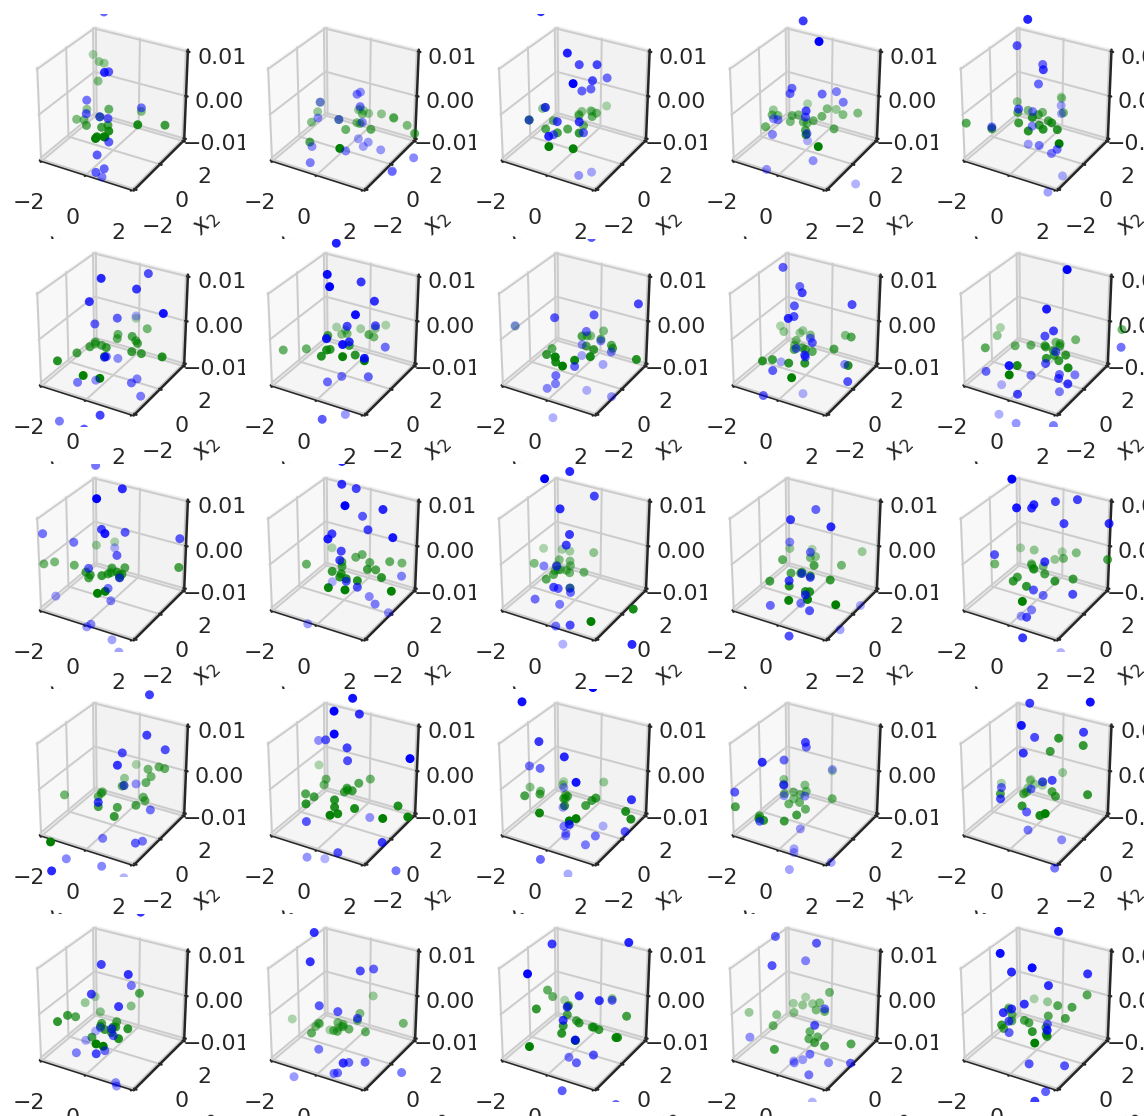

In [27]:
#hide
fig = plt.figure(figsize=(10,10))

for i in range(n_ind):
  ax = fig.add_subplot(np.ceil(np.sqrt(n_ind)), np.ceil(np.sqrt(n_ind)),
                       i+1, projection='3d')
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_zlabel('y');
  ax.set_xlim(-2, 2)
  ax.set_ylim(-2, 2)
  ax.set_zlim(-0.01, 0.01)
  ax.scatter(x1_train[i,:,:], x2_train[i,:,:], y_hat[i,:],
             #c=y_pred[i,:],
             color='green',
             linewidth=0.0);
  ax.scatter(x1_train[i,:,:], x2_train[i,:,:], y_train[i,:,:],
             #c=y_train[i,:,:],
             #cmap='gray',
             c='blue',
             linewidth=0.0);


plt.show()

## Test set performance

In [28]:
X_valid = np.stack((x1_valid.reshape(n_ind*npi*n_time_steps_valid),
                    x2_valid.reshape(n_ind*npi*n_time_steps_valid)), 1)

X_valid = np.column_stack((X_valid, np.repeat(industry_loadings, n_time_steps_valid, 0)))
Y_valid = y_valid.reshape(n_ind*npi*n_time_steps_valid)

In [29]:
ann_input.set_value(X_valid)
ann_output.set_value(Y_valid)
ppc = pm.sample_posterior_predictive(trace, model=neural_network, samples=1000)

100%|██████████| 1000/1000 [00:21<00:00, 46.00it/s]


In [30]:
y_hat_valid = ppc['out'].mean(0).reshape(n_ind, npi*n_time_steps_valid)
mse(y_hat_valid, Y_valid.reshape(n_ind, npi*n_time_steps_valid))    

0.00031069348661924285

The figure below shows the predictions (green) and targets (blue) per sector for the standard model.

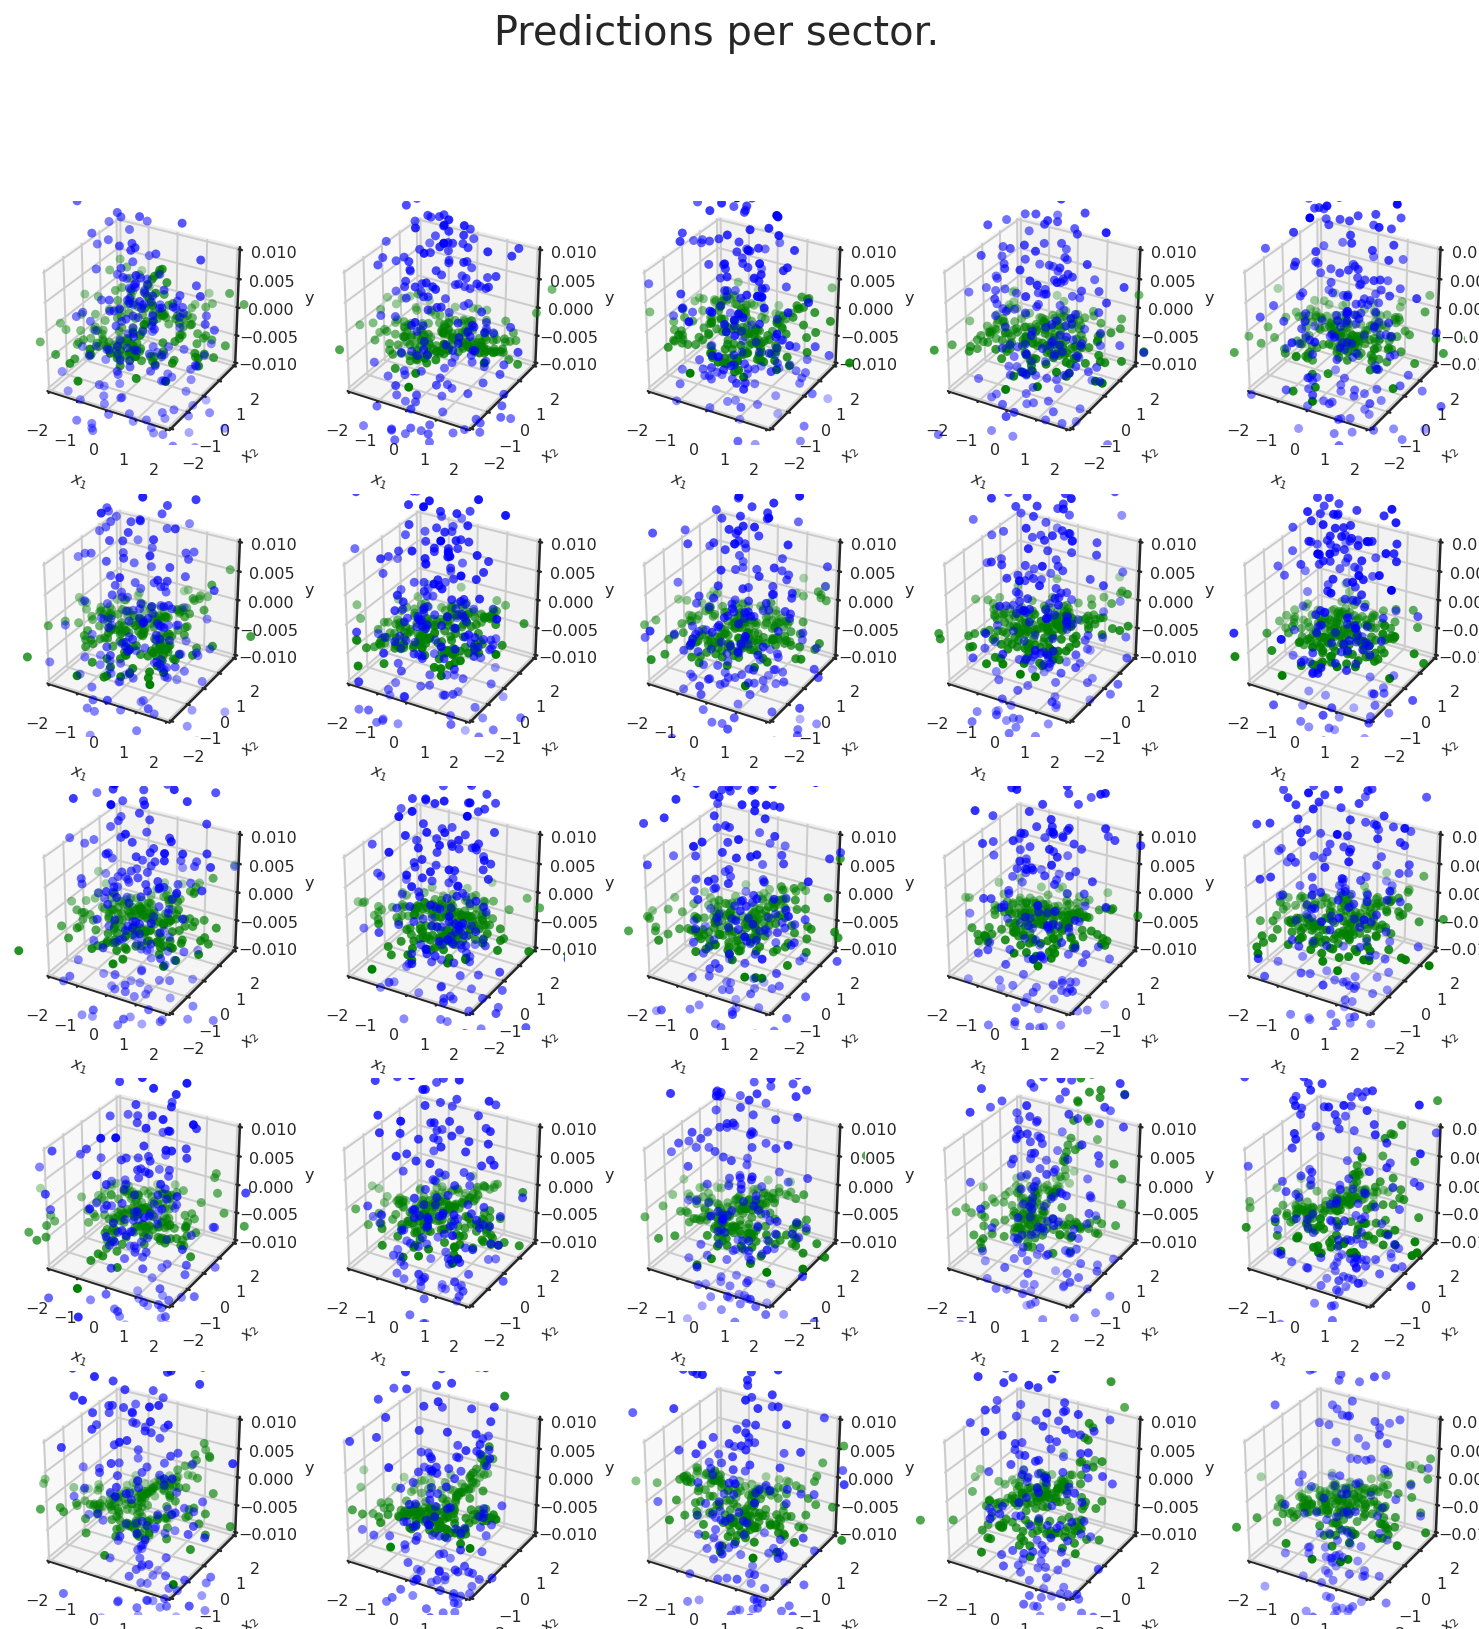

In [31]:
fig = plt.figure(figsize=(13,13))
fig.suptitle('Predictions per sector.', fontsize=20)

for i in range(n_ind):
  ax = fig.add_subplot(np.ceil(np.sqrt(n_ind)), np.ceil(np.sqrt(n_ind)),
                       i+1, projection='3d')
  ax.set_xlabel('$x_1$', fontsize=8)
  ax.set_ylabel('$x_2$', fontsize=8)
  ax.set_zlabel('y', fontsize=8);
  ax.tick_params(labelsize=8);
  ax.set_xlim(-2, 2)
  ax.set_ylim(-2, 2)
  ax.set_zlim(-0.01, 0.01)
  ax.scatter(x1_valid[i,:,:], x2_valid[i,:,:], y_hat_valid[i,:],
             #c=y_pred[i,:],
             #cmap='Greens',
             c='green',
             linewidth=0.0);
  ax.scatter(x1_valid[i,:,:], x2_valid[i,:,:], y_valid[i,:,:],
             #c=y_valid[i,:,:],
             #cmap='gray',
             c='blue',
             linewidth=0.0);


plt.show()

In [32]:
ir, rets = get_ir(log_rets=torch.tensor(Y_valid.reshape(n_stocks, n_time_steps_valid)).T,
       Y_hat=torch.tensor(y_hat_valid.reshape(n_stocks, n_time_steps_valid)).T,
       inv_cov_tensor=inv_cov_tensor)

Test set information ratio: 4.656724278111963


Text(0, 0.5, 'cumulative portfolio log-returns')

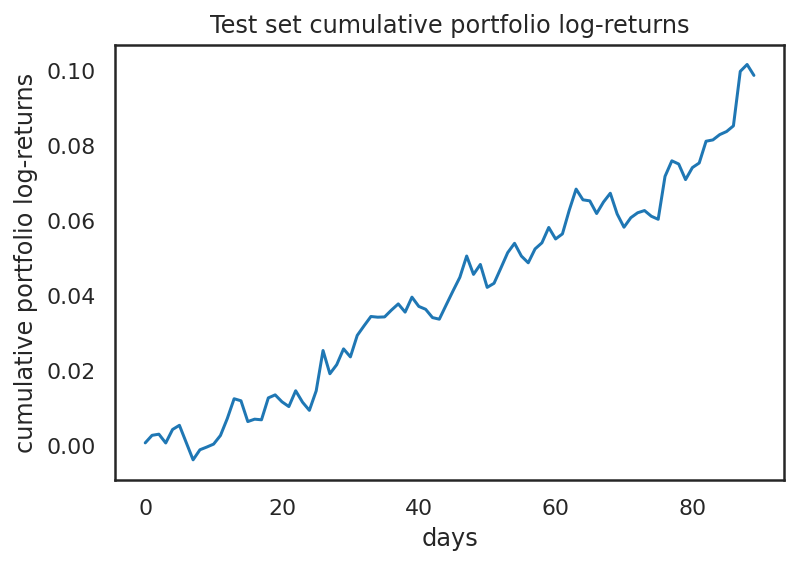

In [33]:
print('Test set information ratio:', ir)
plt.plot(np.cumsum(rets))
plt.title('Test set cumulative portfolio log-returns')
plt.xlabel('days')
plt.ylabel('cumulative portfolio log-returns')

# Eigenvectors of the covariance matrix as encodings

Here we use the eigenvectors of the high-frequency estimates of the integrated covariance matrix averaged over all days of the training set as asset encodings. The true covariance matrix has a low-rank plus block-diagonal plus diagonal structure.

In [34]:

X_train = np.stack((x1_train.reshape(n_ind*npi*n_time_steps_train),
                    x2_train.reshape(n_ind*npi*n_time_steps_train)), 1)

# number of principal components, 0 if all. 
n_pc = 0

evectors = np.linalg.eigh(cov_avg)[1][:, -n_pc:]
# evectors = np.linalg.eigh(u.uncond_cov())[1][:, -n_pc:]

X_train = np.column_stack((X_train,
                           np.repeat(evectors,
                                     n_time_steps_train, 0)))

Y_train = y_train.reshape(n_ind*npi*n_time_steps_train)


ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = [10, 5]
n_data = X_train.shape[1]


# Initialize random weights between each layer
init_1 = np.random.randn(n_data, n_hidden[0]).astype(theano.config.floatX)
init_2 = np.random.randn(n_hidden[0], n_hidden[1]).astype(theano.config.floatX)
init_out = np.random.randn(n_hidden[1]).astype(theano.config.floatX)
    
with pm.Model() as neural_network:
    weights_in_1 = pm.Normal('w_in_1_grp', 0, sd=1, 
                              shape=(n_data, n_hidden[0]), 
                              testval=init_1)

    weights_1_2 = pm.Normal('w_1_2_grp', 0, sd=1, 
                            shape=(n_hidden[0], n_hidden[1]), 
                            testval=init_2)

    weights_2_out = pm.Normal('w_2_out_grp', 0, sd=1, 
                              shape=(n_hidden[1],), 
                              testval=init_out)

    # Build neural-network using relu activation function
    act_1 = tt.nnet.relu(tt.dot(ann_input, 
                         weights_in_1))
    act_2 = tt.nnet.relu(tt.dot(act_1, 
                         weights_1_2))
    
    # linear output layer
    intercept = pm.Normal('intercept', mu=0, sd=10)
    act_out = tt.dot(act_2, weights_2_out) + intercept
        
    sigma = pm.HalfNormal('sigma', sd=10)
    out = pm.Normal('out', 
                    act_out,
                    sigma,
                    observed=ann_output)

In [35]:

with neural_network:
    trace = pm.sample(
                     init='advi+adapt_diag', tune=50, chains=1, n_init=200000,
                     nuts_kwargs={'target_accept': 0.9},)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = -1,255.9:  25%|██▌       | 50777/200000 [01:14<03:40, 677.03it/s]
Convergence achieved at 50800
Interrupted at 50,799 [25%]: Average Loss = -391.92
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, intercept, w_2_out_grp, w_1_2_grp, w_in_1_grp]
100%|██████████| 550/550 [03:49<00:00,  2.39it/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7178717347662558, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


## Train set performance


In [36]:
ppc = pm.sample_posterior_predictive(trace, model=neural_network, samples=1000)
y_hat = ppc['out'].mean(0).reshape(n_ind, npi*n_time_steps_train)
mse(y_hat, Y_train.reshape(n_ind, npi*n_time_steps_train))    

100%|██████████| 1000/1000 [00:15<00:00, 66.32it/s]


0.00015556828542499416

## Test set performance


In [37]:
X_valid = np.stack((x1_valid.reshape(n_ind*npi*n_time_steps_valid),
                    x2_valid.reshape(n_ind*npi*n_time_steps_valid)), 1)

X_valid = np.column_stack((X_valid, np.repeat(evectors, n_time_steps_valid, 0)))
Y_valid = y_valid.reshape(n_ind*npi*n_time_steps_valid)

In [38]:
ann_input.set_value(X_valid)
ann_output.set_value(Y_valid)
ppc = pm.sample_posterior_predictive(trace, model=neural_network, samples=1000)

100%|██████████| 1000/1000 [00:22<00:00, 43.84it/s]


In [39]:
y_hat_valid = ppc['out'].mean(0).reshape(n_ind, npi*n_time_steps_valid)
mse(y_hat_valid, Y_valid.reshape(n_ind, npi*n_time_steps_valid))    

0.00031774646216500347

In [40]:
ir, rets = get_ir(log_rets=torch.tensor(Y_valid.reshape(n_stocks, n_time_steps_valid)).T,
       Y_hat=torch.tensor(y_hat_valid.reshape(n_stocks, n_time_steps_valid)).T,
       inv_cov_tensor=inv_cov_tensor)

Test set information ratio: 6.472823754383646


Text(0, 0.5, 'cumulative portfolio log-returns')

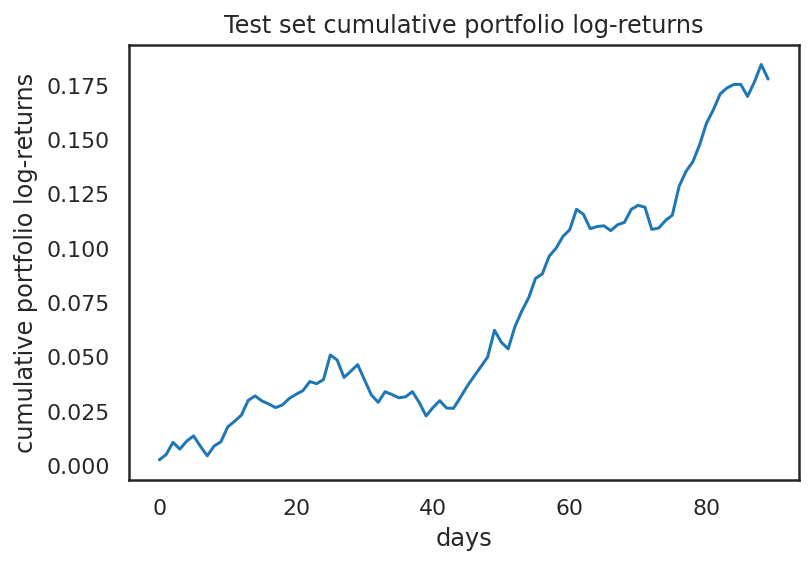

In [41]:
print('Test set information ratio:', ir)
plt.plot(np.cumsum(rets))
plt.title('Test set cumulative portfolio log-returns')
plt.xlabel('days')
plt.ylabel('cumulative portfolio log-returns')

# Conclusion

Hierarchical neural networks can successfully model panel data of asset returns with sector dependent data generating functions by sharing information via informative priors. Still, standard neural networks are surprisingly good at capturing the sector differences as well if the sector is given as a one-hot encoded matrix as long as the number of 
sectors is reasonable relative to the product of $n$ and 
$p$. However, if the number of sectors is close to $p$ and $\frac{n}{p}$ is small, modeling the structure via hierarchical neural networks clearly outperforms standard neural networks.

In [43]:
#hide
! pip install watermark
%load_ext watermark

In [44]:
#hide_input
%watermark -v -m -p numpy,numba,hfhd,scipy,theano,pymc3,matplotlib

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
numba 0.51.2
hfhd 0.1.4
scipy 1.4.1
theano 1.0.5
pymc3 3.7
matplotlib 3.2.2

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
